In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import requests
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import pearsonr, spearmanr
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [25]:
# Set the path to the file you'd like to load
file_path = "weekly_player_stats_offense.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "philiphyde1/nfl-stats-1999-2022",
  file_path,
)

import requests

# Years you want to pull
years = range(2016, 2024)  # Adjust as needed
all_adp = []

for y in years:
    url = f"https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year={y}&position=all"
    try:
        r = requests.get(url)
        r.raise_for_status()
        data = r.json()

        # Each player entry is in data["players"]
        df_adp = pd.DataFrame(data["players"])
        df_adp["season"] = y
        all_adp.append(df_adp)
        print(f"{y} — {len(df_adp)} players loaded")
    except Exception as e:
        print(f"Error for {y}: {e}")

# Combine all into one DataFrame
adp_all = pd.concat(all_adp, ignore_index=True)

# Optional: clean player names
adp_all["name"] = adp_all["name"].str.strip()

# Preview
print(adp_all.head())

# Save to JSON if you want a file
adp_all.to_json("historical_adp_ppr.json", orient="records")

# --- Step 1: pick only the columns you want from ADP ---
# Example: name, position, team, average ADP, and season
# --- Step 1: pick only needed columns ---
adp_keep = adp_all[["name", "position", "team", "adp", "season"]].copy()

# --- Step 2: normalize player names for matching ---
adp_keep["player_name_merge"] = (
    adp_keep["name"]
    .str.strip()
    .str.replace(r"\s+Jr\.?$", "", regex=True)
    .str.replace(r"\s+Sr\.?$", "", regex=True)
)

# --- Step 3: average ADP per player-season ---
# If there are multiple ADP rows for the same player/season, this averages them
adp_all = (
    adp_keep
    .groupby(["season", "player_name_merge"], as_index=False)
    .agg({
        "adp": "first",          # average the ADP values
        }))

# --- Step 4: prep your main DF for merge ---
df["player_name_merge"] = (
    df["player_name"]
    .str.strip()
    .str.replace(r"\s+Jr\.?$", "", regex=True)
    .str.replace(r"\s+Sr\.?$", "", regex=True)
)

# --- Step 5: merge the averaged ADP into your stats ---
df= df.merge(adp_all, on=["season", "player_name_merge"], how="left")

# --- Step 6: check result ---
print(df[["player_name", "season", "adp", "position", "team"]].head())


/tmp/ipython-input-3391441060.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


2016 — 188 players loaded
2017 — 184 players loaded
2018 — 197 players loaded
2019 — 200 players loaded
2020 — 203 players loaded
2021 — 211 players loaded
2022 — 157 players loaded
2023 — 202 players loaded
   player_id               name position team  adp adp_formatted  \
0       1886      Antonio Brown       WR  PIT  1.2          1.01   
1       1796        Julio Jones       WR  ATL  2.8          1.03   
2       2113  Odell Beckham Jr.       WR  NYG  3.4          1.03   
3       2297      David Johnson       RB  ARI  3.4          1.03   
4       2280        Todd Gurley       RB  LAR  6.3          1.06   

   times_drafted  high  low  stdev  bye  season  
0            454     1    4    0.5    5    2016  
1            348     1    6    0.9    5    2016  
2            512     1   10    1.2   14    2016  
3            146     1    7    1.5    8    2016  
4            470     1   12    1.8    8    2016  
     player_name  season  adp position team
0  Charlie Batch    2012  NaN       QB 

In [26]:
df=df[df["season"]>=2016]
df=df[df["season"]<=2022]
print(df["adp"])

15557    68.5
15558    68.5
15559    68.5
15560    68.5
15561    68.5
         ... 
48545     NaN
48546     NaN
48547     NaN
48548     NaN
48549     NaN
Name: adp, Length: 32993, dtype: float64


Train R²: 0.685
Test R²: 0.612
Cross-validated R² scores: [0.57178247 0.57403153 0.33271931 0.46669854 0.65565728]
Mean CV R²: 0.520


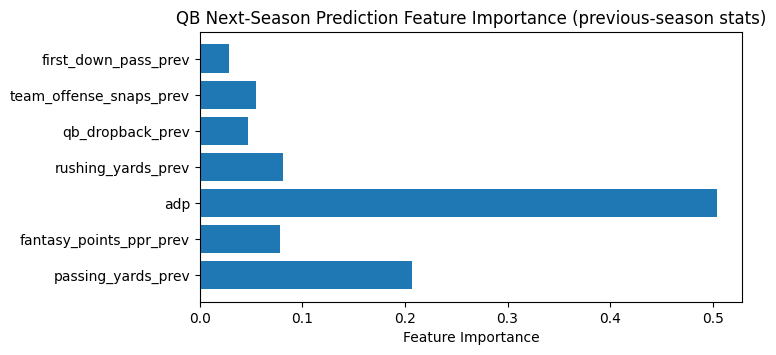


Top predictions (sorted by predicted value):
      player_id      player_name  season  target_season_actual  \
269  00-0034857       Josh Allen    2021             28.307778   
270  00-0034857       Josh Allen    2022             27.863529   
280  00-0035228     Kyler Murray    2021             24.841429   
243  00-0033873  Patrick Mahomes    2022             28.311000   
231  00-0033537   Deshaun Watson    2019             25.325000   
232  00-0033537   Deshaun Watson    2020             26.895000   
260  00-0034796    Lamar Jackson    2020             23.798667   
241  00-0033873  Patrick Mahomes    2020             28.422222   
242  00-0033873  Patrick Mahomes    2021             26.346316   
102  00-0029263   Russell Wilson    2018             22.838750   
105  00-0029263   Russell Wilson    2021             20.701429   
299  00-0036355   Justin Herbert    2022             19.191765   
240  00-0033873  Patrick Mahomes    2019             26.622353   
261  00-0034796    Lamar Jacks

In [27]:
# Predict next-season QB performance using previous-season stats
# Uses the same column names referenced in your clipboarded code.
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np

# df is assumed to already exist and contain your raw play/week-level data
# Keep only QBs and required dtypes (adapted from your clipboard)
# Use 'position' from the merged dataframe
df = df[df['position'] == 'QB'].copy()

df['week'] = df['week'].astype(int)
df['season'] = df['season'].astype(int)
# ensure fantasy column is float if present
# Use the appropriate fantasy points column from the merged dataframe (likely 'fantasy_points_ppr' or 'season_average_fantasy_points_ppr')
# Let's assume 'fantasy_points_ppr' is the one from the original stats data
if 'fantasy_points_ppr' in df.columns:
    df['fantasy_points_ppr'] = df['fantasy_points_ppr'].astype(float)
    fantasy_points_col = 'fantasy_points_ppr'
elif 'season_average_fantasy_points_ppr' in df.columns:
     df['season_average_fantasy_points_ppr'] = df['season_average_fantasy_points_ppr'].astype(float)
     fantasy_points_col = 'season_average_fantasy_points_ppr'
else:
    raise KeyError("No suitable fantasy points column found in the dataframe.")


# 1) Aggregate season-level numeric stats per player-season (season totals / means as appropriate)
numeric_cols = df.select_dtypes(include='number').columns.tolist()
# keep player_id, player_name, season for grouping
group_cols = ['player_id', 'season']
# Remove 'season' and 'adp' from the columns to be aggregated with sum
agg_cols = {c: 'sum' for c in numeric_cols if c not in group_cols and c != "fantasy_points_ppr"}
# Add adp with 'mean' aggregation
agg_cols['fantasy_points_ppr'] = 'mean'


season_agg = df.groupby(group_cols).agg(
    agg_cols
).reset_index() # season is now correctly a column after reset_index


# Optionally also keep player_name (first occurrence)
if 'player_name' in df.columns:
    names = df.groupby(group_cols)['player_name'].first().reset_index()
    # Merge on group_cols after reset_index
    season_agg = season_agg.merge(names[['player_id', 'season', 'player_name']], on=['player_id', 'season'], how='left')


# 2) Build previous-season features -> next-season target
# shift season by +1 to align previous season stats with the following season target
prev = season_agg.copy()
prev['season'] = prev['season'] + 1
# suffix previous-season feature names with _prev so they are explicit
prev = prev.add_suffix('_prev')
# fix column names for join: player_id_prev and season_prev exist; we will join on those matching current season
# prepare current-season frame (target season)
curr = season_agg.copy()
# Merge prev (previous-season stats) onto curr (current season) using player_id and season
merged_prev_next = curr.merge(
    prev,
    left_on=['player_id', 'season'],
    right_on=['player_id_prev', 'season_prev'],
    how='inner'  # inner join ensures we only keep seasons where previous season data exists
)

# 3) Choose features and target using same column names where possible
# Example feature columns (from your clipboard): passing_yards, fantasy_points_ppr, qb_dropback, team_offense_snaps, first_down_pass, adp
# We expect these to exist as numeric season aggregates in season_agg; adjust if your column names differ.
# Use the appropriate column names from the merged dataframe


# Create list of features from the previous-season suffixed columns
features = [    'passing_yards_prev', 'fantasy_points_ppr_prev', 'adp',
            "rushing_yards_prev","qb_dropback_prev","team_offense_snaps_prev","first_down_pass_prev"
]

# Define target as the current season's season_average_fantasy_points_ppr if available,
# otherwise fall back to the aggregated fantasy points column.
# Use the appropriate target column from the merged dataframe
if 'season_average_fantasy_points_ppr' in merged_prev_next.columns:
    target = 'fantasy_points_ppr'
elif fantasy_points_col in merged_prev_next.columns:
    target = fantasy_points_col
else:
    raise KeyError("No suitable target column found in the merged dataframe.")


# Drop rows with NaNs in features/target
model_df = merged_prev_next.dropna(subset=features + [target]).copy()

# Basic train/test split
X = model_df[features]
y = model_df[target]
identifiers = model_df[['player_id', 'season', 'player_name']] if 'player_name' in model_df.columns else model_df[['player_id', 'season']]

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, identifiers.index, test_size=0.3, random_state=42
)

# 4) Model (RandomForestRegressor with overfitting control like your clipboard)
model = RandomForestRegressor(
    n_estimators=650,
    min_samples_split=7,
    min_samples_leaf=8,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# Evaluate
train_r2 = model.score(X_train, y_train)
test_r2 = model.score(X_test, y_test)
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")

# Cross-validation on full dataset
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2', n_jobs=-1)
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.3f}")

# Feature importance plot
importances = model.feature_importances_
plt.figure(figsize=(7, max(3, len(features) * 0.5)))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("QB Next-Season Prediction Feature Importance (previous-season stats)")
plt.show()

# 5) Generate predictions and results table (predicting current season using previous-season stats)
preds = model.predict(X)
results = pd.DataFrame({
    'player_id': identifiers.loc[X.index, 'player_id'],
    'player_name': identifiers.loc[X.index, 'player_name'] if 'player_name' in identifiers.columns else np.nan,
    'season': identifiers.loc[X.index, 'season'],
    'target_season_actual': y,
    'predicted_from_prev_season': preds,
    'error': y - preds,
    'adp': model_df['adp']
}, index=X.index)

# show top results by predicted value
print("\nTop predictions (sorted by predicted value):")
print(results.sort_values('predicted_from_prev_season', ascending=False).head(15))

# Optional: export results
# results.to_csv("qb_next_season_predictions_from_prev.csv", index=False)


In [28]:
# Rank players by ADP (lower ADP = better rank)
results["adp"]=results["adp"].replace(0,np.inf)
results["adp_rank"] = results.groupby("season")["adp"].rank(method="min", ascending=True)

# Rank players by predicted performance (higher predicted points = better rank)
results["predicted_rank"] = results.groupby("season")["predicted_from_prev_season"] \
                                   .rank(method="min", ascending=False)

# Optional: difference between how your model ranks them and how the market ranked them
results["rank_diff"] = results["predicted_rank"] - results["adp_rank"]

# Now you can sort by rank_diff to find biggest sleepers / overvalued players
print(results.sort_values(["season", "rank_diff"],ascending=False).head(15))


      player_id      player_name  season  target_season_actual  \
262  00-0034796    Lamar Jackson    2022              1.340000   
309  00-0037012       Trey Lance    2022              6.230000   
223  00-0033275      P.J. Walker    2022              7.523333   
112  00-0029567       Nick Foles    2022              0.900000   
59   00-0026158       Joe Flacco    2022             10.928000   
233  00-0033662      Cooper Rush    2022              8.330000   
286  00-0035289  Gardner Minshew    2022              6.936667   
64   00-0026300     Josh Johnson    2022              0.160000   
247  00-0033936    C.J. Beathard    2022             -0.250000   
256  00-0034577       Kyle Allen    2022              9.470000   
250  00-0033958  Nathan Peterman    2022              3.420000   
297  00-0036264      Jordan Love    2022              3.425000   
277  00-0035040     David Blough    2022             10.790000   
304  00-0036879     Sam Ehlinger    2022             10.155000   
63   00-00

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Assume df is already loaded and filtered for QBs from 2016-2022 (as per cell T9WZ8koDR4Yp)
# The variable 'df' in this cell should be the filtered QB dataframe.
# To ensure this, let's explicitly filter 'df' again for clarity, though it might be redundant if T9WZ8koDR4Yp ran just before.
# If running this cell independently, you might need to re-run cell T9WZ8koDR4Yp first to get the correct 'df'.

# Let's assume df is the QB dataframe from 2016-2022
# df = df[(df['season'] >= 2016) & (df['season'] <= 2022)].copy() # This should have been done upstream
# df = df[df['position'] == 'QB'].copy() # This should have been done upstream

# 1) Aggregate season-level numeric stats per player-season
# Group by player_id and season, and sum numeric columns.
# 'season' is included in the groupby key, so it will become part of the index.
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
group_cols = ['player_id', 'season']

# Create aggregation dictionary, excluding the grouping columns from the sum list
agg_dict = {c: 'sum' for c in numeric_cols if c not in group_cols and c != "fantasy_points_ppr"}
# Add adp with 'mean' aggregation
agg_dict['fantasy_points_ppr'] = 'mean'
season_agg = df.groupby(group_cols).agg(agg_dict).reset_index()

# Optionally also keep player_name (first occurrence)
if 'player_name' in df.columns:
    names = df.groupby(group_cols)['player_name'].first().reset_index()
    season_agg = season_agg.merge(names[['player_id', 'season', 'player_name']], on=['player_id', 'season'], how='left')


# 2) Build previous-season features -> next-season target
# Prepare previous-season feature: use previous season's fantasy points
# Determine which fantasy column to use as the feature and target
feat_col = None
target_col = None

# First, let's make sure the necessary columns exist in season_agg after aggregation
# Note: 'fantasy_points_ppr' or 'season_average_fantasy_points_ppr'
# should ideally come from the aggregation or be merged subsequently.
# Based on cell T9WZ8koDR4Yp, 'fantasy_points_ppr' seems to be an aggregated column.
# 'season_average_fantasy_points_ppr' might also be available or calculated.

# Let's check which columns are available in season_agg for fantasy points
available_fantasy_cols = [col for col in ['fantasy_points_ppr'] if col in season_agg.columns]

if not available_fantasy_cols:
    raise KeyError("Missing required fantasy columns ('fantasy_points_ppr' or 'season_average_fantasy_points_ppr') in aggregated data.")

# Use the first available fantasy column for both feature and target for this baseline model
# If season_average_fantasy_points_ppr exists, use it for the target. Otherwise use fantasy_points_ppr
target_col = "fantasy_points_ppr"
    # Use fantasy_points_ppr for the feature if available, otherwise use the target_col
feat_col = 'adp'


prev = season_agg.copy()
prev['season'] = prev['season'] + 1
# Rename the feature column with _prev suffix
if feat_col in prev.columns:
    prev = prev[['player_id', 'season', feat_col]].rename(columns={feat_col: feat_col + '_prev'})
else:
     raise KeyError(f"Feature column '{feat_col}' not found in previous season data.")


curr = season_agg.copy()
# Merge prev (previous-season stats) onto curr (current season) using player_id and season
merged_baseline = curr.merge(prev, on=['player_id', 'season'], how='inner')

# Keep only rows without NaNs in feature/target
merged_baseline = merged_baseline.dropna(subset=[feat_col + '_prev', target_col]).copy()

# Baseline feature matrix and target
X = merged_baseline[[feat_col]].values  # single-feature baseline
y = merged_baseline[target_col].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model: simple linear regression baseline
baseline_model = RandomForestRegressor(
    n_estimators=650,
    min_samples_split=7,
    min_samples_leaf=6,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_train = baseline_model.predict(X_train)
y_pred_test = baseline_model.predict(X_test)

print(f"Train R²: {r2_score(y_train, y_pred_train):.3f}")
print(f"Test R²: {r2_score(y_test, y_pred_test):.3f}")
# Need to import mean_absolute_error if not already imported
# from sklearn.metrics import mean_absolute_error
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test):.3f}")

# Cross-validated R²
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.3f}")

# Results dataframe with player info and errors
# Ensure columns used exist in merged_baseline
results = pd.DataFrame({
    'player_id': merged_baseline['player_id'],
    'player_name': merged_baseline['player_name'] if 'player_name' in merged_baseline.columns else np.nan,
    'season': merged_baseline['season'],
    'adp': merged_baseline[feat_col],
    'actual_target_season': merged_baseline[target_col],
    'predicted_target_season': baseline_model.predict(merged_baseline[[feat_col]].values)
})

results['error'] = results['actual_target_season'] - results['predicted_target_season']

# Show top 10 by prev_season_fantasy
print("\nBaseline predictions (top by previous-season fantasy):")
print(results.sort_values("adp", ascending=False).head(10))


Train R²: 0.474
Test R²: 0.556
Test MAE: 4.904
Cross-validated R² scores: [0.39931017 0.42188446 0.14975648 0.530735   0.611152  ]
Mean CV R²: 0.423

Baseline predictions (top by previous-season fantasy):
      player_id      player_name  season     adp  actual_target_season  \
199  00-0032950     Carson Wentz    2021  2840.7             17.824706   
158  00-0031345  Jimmy Garoppolo    2019  2802.5             16.605263   
202  00-0033077     Dak Prescott    2018  2696.2             20.167059   
307  00-0036971  Trevor Lawrence    2022  2572.2             19.216667   
27   00-0022942    Philip Rivers    2020  2553.6             17.810000   
149  00-0031280       Derek Carr    2019  2518.4             17.710000   
17   00-0022803      Eli Manning    2018  2515.2             16.997500   
124  00-0029701   Ryan Tannehill    2020  2502.4             25.585000   
212  00-0033106       Jared Goff    2020  2502.4             17.655294   
264  00-0034855   Baker Mayfield    2020  2459.9       

In [30]:
print(len(results['predicted_target_season'].unique()))
print(len(results['actual_target_season'].unique()))

108
309


In [31]:
import requests
df_real = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "philiphyde1/nfl-stats-1999-2022",
  file_path,
)
df_real=df_real[df_real["season"]==2024]
df_real["season"]+=1
# Years you want to pull
years = 2025  # Adjust as needed
all_adp = []

# Ensure years is an iterable even if it's a single integer
if isinstance(years, int):
    years_list = [years]
else:
    years_list = years


for y in years_list:
    url = f"https://fantasyfootballcalculator.com/api/v1/adp/ppr?teams=12&year=2025&position=all"
    try:
        r = requests.get(url)
        r.raise_for_status()
        data = r.json()

        # Each player entry is in data["players"]
        df_adp = pd.DataFrame(data["players"])
        df_adp["season"] = y
        all_adp.append(df_adp)
        print(f"{y} — {len(df_adp)} players loaded")
    except Exception as e:
        print(f"Error for {y}: {e}")

# Combine all into one DataFrame
adp_all = pd.concat(all_adp, ignore_index=True)

# Optional: clean player names
adp_all["name"] = adp_all["name"].str.strip()

# Preview
print(adp_all.head())

# Save to JSON if you want a file
adp_all.to_json("historical_adp_ppr.json", orient="records")

# --- Step 1: pick only the columns you want from ADP ---
# Example: name, position, team, average ADP, and season
# --- Step 1: pick only needed columns ---
adp_keep = adp_all[["name", "position", "team", "adp", "season"]].copy()

# --- Step 2: normalize player names for matching ---
adp_keep["player_name_merge"] = (
    adp_keep["name"]
    .str.strip()
    .str.replace(r"\s+Jr\.?$", "", regex=True)
    .str.replace(r"\s+Sr\.?$", "", regex=True)
)

# --- Step 3: average ADP per player-season ---
# If there are multiple ADP rows for the same player/season, this averages them
adp_all = (
    adp_keep
    .groupby(["season", "player_name_merge"], as_index=False)
    .agg({
        "adp": "first",          # average the ADP values
        }))

# --- Step 4: prep your main DF for merge ---
df_real["player_name_merge"] = (
    df_real["player_name"]
    .str.strip()
    .str.replace(r"\s+Jr\.?$", "", regex=True)
    .str.replace(r"\s+Sr\.?$", "", regex=True)
)

# --- Step 5: merge the averaged ADP into your stats ---
df_real= df_real.merge(adp_all, on=["season", "player_name_merge"], how="left")

# --- Step 6: check result ---
print(df_real[["player_name", "season", "adp", "position", "team"]].head())
print(df_real)


/tmp/ipython-input-2471927008.py:2: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df_real = kagglehub.load_dataset(


2025 — 244 players loaded
   player_id              name position team  adp adp_formatted  \
0       5177     Ja'Marr Chase       WR  CIN  1.5          1.02   
1       5670    Bijan Robinson       RB  ATL  2.2          1.02   
2       2860    Saquon Barkley       RB  PHI  2.5          1.02   
3       5672      Jahmyr Gibbs       RB  DET  4.0          1.04   
4       4876  Justin Jefferson       WR  MIN  4.9          1.05   

   times_drafted  high  low  stdev  bye  season  
0           1793     1    5    0.8   10    2025  
1           1223     1    5    0.8    5    2025  
2            758     1    7    1.0    9    2025  
3           1735     1    8    1.1    8    2025  
4           1431     1   10    1.4    6    2025  
     player_name  season    adp position team
0  Aaron Rodgers    2025  165.1       QB  NYJ
1  Aaron Rodgers    2025  165.1       QB  NYJ
2  Aaron Rodgers    2025  165.1       QB  NYJ
3  Aaron Rodgers    2025  165.1       QB  NYJ
4  Aaron Rodgers    2025  165.1       QB 

In [32]:
QB_2025 = (
    df_real[df_real["position"] == "QB"]
    .groupby(["player_name", "season"])
    .sum(numeric_only=True)   # sums all numeric columns
    .reset_index()
)
QB_2025["adp_true"]=df_real["adp"]
QB_2025=QB_2025.rename(columns={"passing_yards": "passing_yards_prev",
                                "fantasy_points_ppr": "fantasy_points_ppr_prev",
                                "rushing_yards":"rushing_yards_prev",
                                "pass_touchdown":"pass_touchdown_prev",
                                "qb_dropback":"qb_dropback_prev",
                                "first_down_pass":"first_down_pass_prev",
                                "team_offense_snaps":"team_offense_snaps_prev"})
print(QB_2025.sort_values("fantasy_points_ppr_prev", ascending=False))

        player_name  season  week  offense_snaps  offense_pct  \
49    Lamar Jackson    2025   177         1133.0        17.41   
39       Josh Allen    2025   182         1101.0        17.13   
33   Jayden Daniels    2025   198         1212.0        17.40   
35       Joe Burrow    2025   159         1132.0        16.92   
5    Baker Mayfield    2025   160         1123.0        16.75   
..              ...     ...   ...            ...          ...   
32  Jarrett Stidham    2025    25           11.0         0.15   
47       Kyle Trask    2025    31           15.0         0.19   
72     Tyson Bagent    2025    40           13.0         0.21   
61       Sam Howell    2025    15           24.0         0.41   
13     Clayton Tune    2025    52           28.0         0.44   

    team_offense_snaps_prev  birth_year  draft_year  draft_round  draft_pick  \
49                   1169.0       35946     36324.0         18.0       576.0   
39                   1155.0       35928     36324.0        

In [33]:
# --- Config ---
TARGET_SEASON = 2025  # adjust if needed

# --- Helpers ---
def normalize_names(s):
    return s.astype(str).str.strip().str.lower()

def pick_name_column(df, candidates=("name", "player_name", "player")):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of the name columns {candidates} found in {list(df.columns)}")

def pick_adp_column(df, candidates=("adp", "averageDraftPosition", "adp_mean", "adp_overall")):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of the ADP columns {candidates} found in {list(df.columns)}")

# --- 1) Prepare ADP (QB only) ---
QB_adp_raw = adp_keep.loc[adp_keep["position"] == "QB"].copy()

# Optional: filter to the target season if available; otherwise keep latest per player
if "season" in QB_adp_raw.columns:
    if (QB_adp_raw["season"] == TARGET_SEASON).any():
        QB_adp_raw = QB_adp_raw.loc[QB_adp_raw["season"] == TARGET_SEASON].copy()
    else:
        # Fall back to latest season per player
        name_col_tmp = pick_name_column(QB_adp_raw)
        QB_adp_raw = (
            QB_adp_raw.sort_values("season")
                      .drop_duplicates(subset=[name_col_tmp], keep="last")
                      .copy()
        )

# Identify columns reliably
adp_name_col = pick_name_column(QB_adp_raw)
adp_value_col = pick_adp_column(QB_adp_raw)

# Normalize and rename
QB_adp = QB_adp_raw[[adp_name_col, adp_value_col]].copy()
QB_adp["player_name_merge"] = normalize_names(QB_adp[adp_name_col])
QB_adp = QB_adp.rename(columns={adp_value_col: "adp_true"})
QB_adp = QB_adp[["player_name_merge", "adp_true"]]

# --- 2) Prepare predictions ---
pred_name_col = pick_name_column(QB_2025, candidates=("player_name", "name", "player"))
QB_2025 = QB_2025.copy()
QB_2025["player_name_merge"] = normalize_names(QB_2025[pred_name_col])

# Ensure features exist before predict
missing_feats = [f for f in features if f not in QB_2025.columns]
if missing_feats:
    raise KeyError(f"Missing features in QB_2025: {missing_feats}")

QB_2025["predicted_target_season"] = model.predict(QB_2025[features])

# --- 3) Merge and guarantee adp_true exists ---
QB_2025_Results = QB_2025.merge(QB_adp, on="player_name_merge", how="left")

# If for any reason adp_true is missing, recover or create it safely
if "adp_true" not in QB_2025_Results.columns:
    # Try to recover from common ADP names if merge brought a differently named column
    fallback_col = None
    for c in ("adp", "averageDraftPosition", "adp_mean", "adp_overall"):
        if c in QB_2025_Results.columns:
            fallback_col = c
            break
    if fallback_col:
        QB_2025_Results = QB_2025_Results.rename(columns={fallback_col: "adp_true"})
    else:
        QB_2025_Results["adp_true"] = np.nan

# --- 4) Ranking ---
# Treat 0 or NaN ADP as "undrafted": send to bottom by using +inf
adp_keep=adp_keep.replace(0,np.inf)
adp_keep.rename(columns={"adp": "adp_for_rank",
                         "name":"player_name"}, inplace=True)
QB_2025_Results = QB_2025_Results.merge(adp_keep[["player_name", "adp_for_rank"]], on="player_name", how="left")

QB_2025_Results["adp_rank"] = QB_2025_Results["adp_for_rank"].rank(ascending=True, method="min")
QB_2025_Results["predicted_rank"] = QB_2025_Results["predicted_target_season"].rank(ascending=False)

# --- 5) (Optional) Diagnostics ---
unmatched = int(QB_2025_Results["adp_true"].isna().sum())
total = len(QB_2025_Results)
print(f"ADP matches: {total - unmatched}/{total} (unmatched={unmatched})")

# --- 6) View top predictions ---
cols_to_show = [pred_name_col, "predicted_target_season", "adp_true", "adp_rank", "predicted_rank","adp_for_rank"]
print(QB_2025_Results.sort_values("predicted_target_season", ascending=False)[cols_to_show].head(32))


ADP matches: 74/74 (unmatched=0)
           player_name  predicted_target_season  adp_true  adp_rank  \
49       Lamar Jackson                25.685660     374.4       1.0   
39          Josh Allen                25.680538     450.0       2.0   
33      Jayden Daniels                25.659000     617.5       4.0   
29         Jalen Hurts                25.614155     741.6       5.0   
48        Kyler Murray                25.184375    1380.4      10.0   
11      Caleb Williams                25.128503    1769.7      14.0   
5       Baker Mayfield                24.515019     858.5       6.0   
3   Anthony Richardson                24.173425    1829.3       NaN   
58     Patrick Mahomes                24.084977     984.2       7.0   
6               Bo Nix                23.960467    1171.3       8.0   
35          Joe Burrow                23.426903     489.6       3.0   
25          Geno Smith                23.155657    2616.3      22.0   
10         C.J. Stroud                23.124

    adp_for_rank         player_name
0          165.1       Aaron Rodgers
1            NaN     Aidan O'Connell
2            NaN         Andy Dalton
3            NaN  Anthony Richardson
4            NaN        Bailey Zappe
..           ...                 ...
69         139.4      Tua Tagovailoa
70           NaN       Tyler Huntley
71           NaN        Tyrod Taylor
72           NaN        Tyson Bagent
73           NaN          Will Levis

[74 rows x 2 columns]


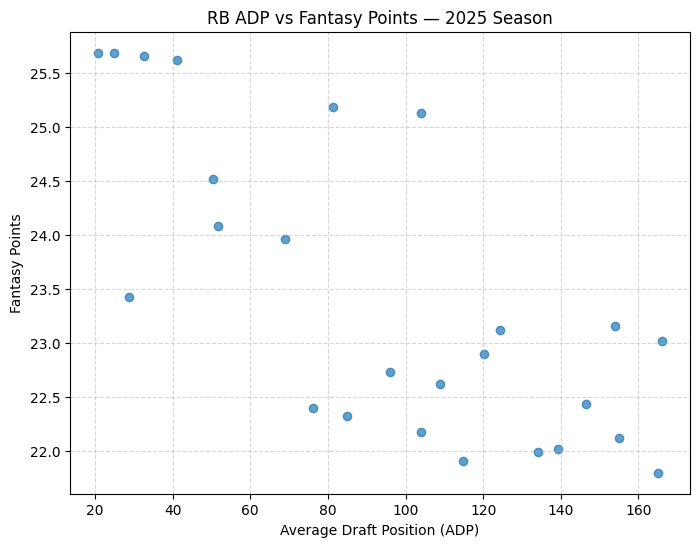

In [34]:
import matplotlib.pyplot as plt
print(QB_2025_Results[["adp_for_rank","player_name"]])
plt.figure(figsize=(8, 6))
plt.scatter(QB_2025_Results["adp_for_rank"], QB_2025_Results["predicted_target_season"], alpha=0.7)

plt.xlabel("Average Draft Position (ADP)")
plt.ylabel("Fantasy Points")
plt.title("RB ADP vs Fantasy Points — 2025 Season")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


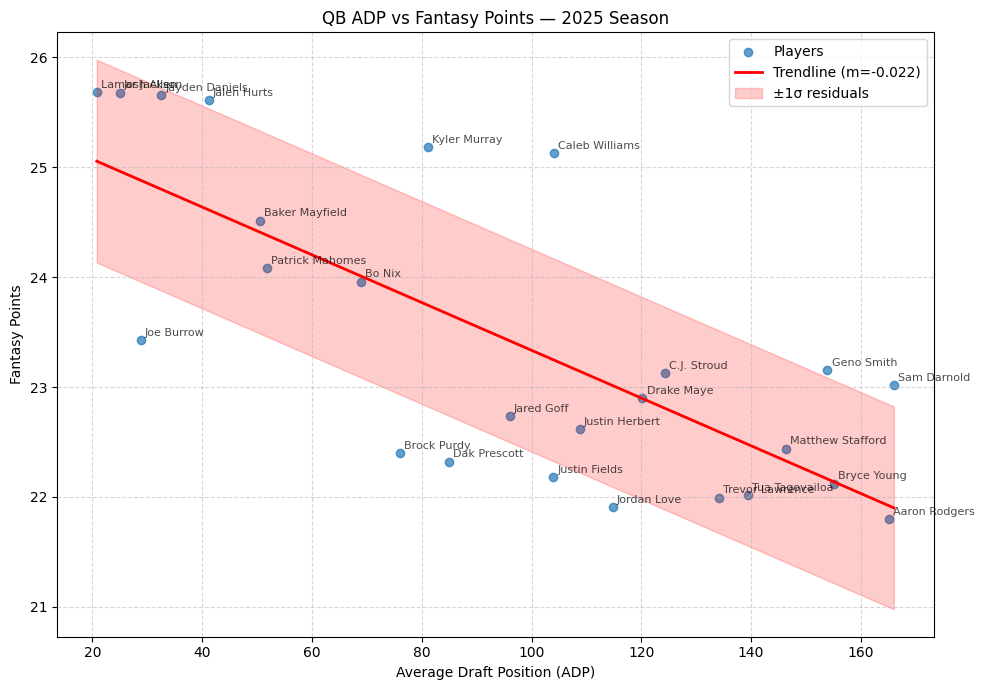

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Columns
xcol = "adp_for_rank"
ycol = "predicted_target_season"

## Include player_name in the dataframe
plot_df = QB_2025_Results[[xcol, ycol, "player_name"]].copy()

# Clean as before
plot_df[xcol] = pd.to_numeric(plot_df[xcol], errors="coerce")
plot_df[ycol] = pd.to_numeric(plot_df[ycol], errors="coerce")
plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[xcol, ycol])
plot_df = plot_df[(plot_df[xcol] >= 1) & (plot_df[xcol] <= 400)]

if plot_df[xcol].nunique() < 2 or len(plot_df) < 3:
    print("Not enough clean data to fit a trendline.")
else:
    x = plot_df[xcol].to_numpy(dtype=float)
    y = plot_df[ycol].to_numpy(dtype=float)
    names = plot_df["player_name"].to_numpy()

    x_c = x - np.mean(x)
    y_c = y - np.mean(y)
    try:
        m, b = np.polyfit(x_c, y_c, 1)
        b = b + np.mean(y) - m * np.mean(x)
    except np.linalg.LinAlgError:
        denom = np.dot(x_c, x_c)
        if denom == 0:
            print("Cannot fit a line: zero variance in x after cleaning.")
            m, b = 0.0, np.mean(y)
        else:
            m = np.dot(x_c, y_c) / denom
            b = np.mean(y) - m * np.mean(x)

    y_pred = m * x + b
    residuals = y - y_pred
    std_dev = residuals.std(ddof=1)

    order = np.argsort(x)
    xs = x[order]
    yps = y_pred[order]

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.7, label="Players")
    plt.plot(xs, yps, color="red", linewidth=2, label=f"Trendline (m={m:.3f})")
    plt.fill_between(xs, yps - std_dev, yps + std_dev, color="red", alpha=0.2, label="±1σ residuals")

    # Annotate each point with player name
    for xi, yi, name in zip(x, y, names):
        plt.annotate(name, (xi, yi), fontsize=8, alpha=0.7, xytext=(3, 3), textcoords="offset points")

    plt.xlabel("Average Draft Position (ADP)")
    plt.ylabel("Fantasy Points")
    plt.title("QB ADP vs Fantasy Points — 2025 Season")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
QB_2025_Results["adp_for_rank"] = QB_2025_Results["adp_for_rank"].fillna(200)
# Columns
xcol = "adp_for_rank"
ycol = "predicted_target_season"

## Include player_name in the dataframe
plot_df = QB_2025_Results[[xcol, ycol, "player_name"]].copy()

# Clean as before
plot_df[xcol] = pd.to_numeric(plot_df[xcol], errors="coerce")
plot_df[ycol] = pd.to_numeric(plot_df[ycol], errors="coerce")
plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna(subset=[xcol, ycol])
plot_df = plot_df[(plot_df[xcol] >= 1) & (plot_df[xcol] <= 400)]

if plot_df[xcol].nunique() < 2 or len(plot_df) < 3:
    print("Not enough clean data to fit a trendline.")
else:
    x = plot_df[xcol].to_numpy(dtype=float)
    y = plot_df[ycol].to_numpy(dtype=float)
    names = plot_df["player_name"].to_numpy()

    x_c = x - np.mean(x)
    y_c = y - np.mean(y)
    try:
        m, b = np.polyfit(x_c, y_c, 1)
        b = b + np.mean(y) - m * np.mean(x)
    except np.linalg.LinAlgError:
        denom = np.dot(x_c, x_c)
        if denom == 0:
            print("Cannot fit a line: zero variance in x after cleaning.")
            m, b = 0.0, np.mean(y)
        else:
            m = np.dot(x_c, y_c) / denom
            b = np.mean(y) - m * np.mean(x)

    y_pred = m * x + b
    residuals = y - y_pred
    std_dev = residuals.std(ddof=1)

    order = np.argsort(x)
    xs = x[order]
    yps = y_pred[order]

    plt.figure(figsize=(10, 7))
    plt.scatter(x, y, alpha=0.7, label="Players")
    plt.plot(xs, yps, color="red", linewidth=2, label=f"Trendline (m={m:.3f})")
    plt.fill_between(xs, yps - std_dev, yps + std_dev, color="red", alpha=0.2, label="±1σ residuals")

    # Annotate each point with player name
    for xi, yi, name in zip(x, y, names):
        plt.annotate(name, (xi, yi), fontsize=8, alpha=0.7, xytext=(3, 3), textcoords="offset points")

    plt.xlabel("Average Draft Position (ADP)")
    plt.ylabel("Fantasy Points")
    plt.title("QB ADP vs Fantasy Points — 2025 Season")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
